# Ex. 2: What Areas Should the Agency Focus On?

What Areas Should the Agency Focus On?

The goal of this exercise is to do explore the data to find the answer to the Question 2 problem statement:

> Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

In this exercise, we will use 311 Dataset to determine whether to focus on any particular borough, ZIP code, or street (where the complaints are severe) for the specific Complaint Type we decided to focus at the end of the last exercise.

## Load and pre-process the data:
First we shall import the required packages, and load the data fram from the CSV file.

Please note that the code below allows to both: load the csv file from the IBM cloud storage and a local csv file. The latter is done for convenience in case one is to re-run the script offline.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
def load_df(file_name):
    df = pd.read_csv('data' + os.path.sep + file_name + '.csv', parse_dates = True, low_memory=False)
    return df

# Load the erm2_nwe9 data set
dhp_df = load_df('erm2_nwe9')

The data pre-processing part is simple and consists of:

1. Selecting the 'HEAT/HOT WATER' complaints, as identified to be the top complaints in **Ex. 1**:

In [2]:
# Select the HEAT/HOT WATER complaints
dhp_df = dhp_df[dhp_df['complaint_type'] == 'HEAT/HOT WATER']

2. Converting the *'created_date'* column into date type and only selecting the complaints up until 31st Dec. 2019:

In [3]:
# Convert the date string to the date type
dhp_df['created_date'] = dhp_df['created_date'].astype('datetime64[ns]')

# Since it is 2020 already and the most recent complaints in
# the data set are of 2020, we shall select the list of complains 
# created before the 31st Dec 2019 as follows:
max_date = np.datetime64('2019-12-31')
dhp_df = dhp_df[dhp_df['created_date'] <= max_date]

3. At last we shall drop the columns that will not be used in the analysis:

In [4]:
# Drop the colums that will not be needed in this analysis
dhp_df.drop(['unique_key', 'complaint_type', 'incident_address',
             'address_type', 'city', 'resolution_description', 
             'location_type', 'closed_date', 'status'], axis = 1, inplace = True)

The resulting data frame looks as follows:

In [5]:
# The resulting initial data frame to work with is:
display(dhp_df.head())

,created_date,incident_zip,street_name,borough,latitude,longitude
10130,2019-12-30 15:34:02,11221.0,JEFFERSON AVENUE,BROOKLYN,40.691831,-73.912753
10131,2019-12-30 14:38:48,10032.0,WEST 157 STREET,MANHATTAN,40.834366,-73.945599
10135,2019-12-30 21:52:11,10016.0,EAST 27 STREET,MANHATTAN,40.741938,-73.982678
10136,2019-12-30 14:44:12,10460.0,ELSMERE PLACE,BRONX,40.842379,-73.886743
10141,2019-12-30 22:41:22,11218.0,MC DONALD AVENUE,BROOKLYN,40.640710,-73.979062


# Analysis for boroughs

In this section we will analyze the number of 'HEAT/HOT WATER' complaints per boroughs per year in order to see which boroughs need more attention.

Note that, we will not need the *'created_date'* column but we shall rather convert it into the year of the complaint. Then we can analyze the complaints per year for different boroughs.

In [6]:
# Let us extract the complaint year from the creation date
dhp_df['year'] = dhp_df.loc[:,'created_date'].apply(lambda x: x.year)

# The creation date is not needed any longer
dhp_df.drop(['created_date'], axis = 1, inplace = True)

# Show the resulting data frame structure
display(dhp_df.head())

,incident_zip,street_name,borough,latitude,longitude,year
10130,11221.0,JEFFERSON AVENUE,BROOKLYN,40.691831,-73.912753,2019
10131,10032.0,WEST 157 STREET,MANHATTAN,40.834366,-73.945599,2019
10135,10016.0,EAST 27 STREET,MANHATTAN,40.741938,-73.982678,2019
10136,10460.0,ELSMERE PLACE,BRONX,40.842379,-73.886743,2019
10141,11218.0,MC DONALD AVENUE,BROOKLYN,40.640710,-73.979062,2019


Now it is time to compute the number of 'HEAT/HOT WATER' complaints per boroughs per year. In this process we will also convert the resulting data frame values into integers, for better readability, and remove a single entry with and unnamed ('Unspecified') borough. The latter will not change the analysis results as this is just one observation being removed.

In [7]:
# Per complaint year per borough and per status count the number of complaints
ybc_cnt_df = dhp_df.groupby(by=['year', 'borough']).size().to_frame()
ybc_cnt_df.columns = ['count']

# Move the indexes into the columns
ybc_cnt_df.reset_index(level = 0, inplace=True)
ybc_cnt_df.reset_index(level = 0, inplace=True)

# Get the number of HEAT/HOT WATER complaints per boroughs per year in a plottable form 
ybc_cnt_df = ybc_cnt_df.pivot(index='borough', columns='year', values='count')

# Drop the Unspecified borough row as there is just one of such rows
ybc_cnt_df.drop(['Unspecified'], axis = 0, inplace = True)

# Convert the floating values into integers
ybc_cnt_df = ybc_cnt_df.astype(int)
ybc_cnt_df

year,2014,2015,2016,2017,2018,2019
borough,,,,,,
BRONX,44925,71865,74201,68718,71454,70110
BROOKLYN,39306,67876,69572,66984,70271,63097
MANHATTAN,30270,54259,51771,46529,49985,47392
QUEENS,16955,29558,30218,29217,29831,28784
STATEN ISLAND,1311,2148,2197,2073,2293,2084


As already aparent from the table above, over the years, 'BRONX' needs most attention with respect to the number of 'HEAT/HOT WATER' complaints. The next closely following borough is BROOKLYN. Let us visualize the data to make it more vivid.

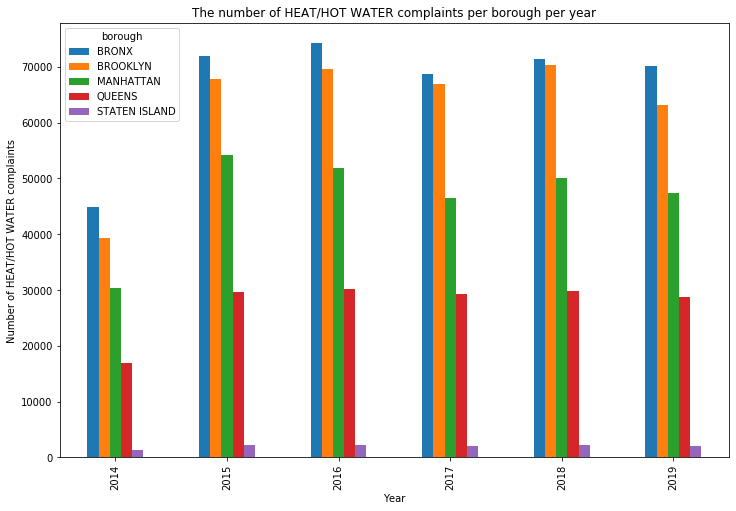

In [8]:
# Here we plot the number of HEAT/HOT WATER complaints per borough per year
ybc_cnt_df.T.plot(kind = 'bar', figsize=(12,8))
plt.title('The number of HEAT/HOT WATER complaints per borough per year')
plt.ylabel('Number of HEAT/HOT WATER complaints')
plt.xlabel('Year')
plt.show()
plt.close()

The plot above shows that except for the first reported year (2014) the complaint numbers per borough do not have drastic drops or increases. Over the year 'BRONX' and then 'BROOKLYN' are leading in the number of 'HEAT/HOT WATER' complaints. This can be further shown by the average number of complaints per borough.

In [9]:
# Compute the number of distinct years in the data set
NUM_YEARS = len(dhp_df['year'].unique())
print('The number of considered years is:', NUM_YEARS)

# Group by the borough and count the total number of
# HEAT/HOT WATER complaints. Then compute the average
# number of complaints per year and finally sort in
# descending order and convert to a data frame.
borough_df = dhp_df.groupby('borough').size().apply(lambda x: x/NUM_YEARS).sort_values(axis=0, ascending = False).to_frame()

# Assign the counts column name
borough_df.columns = ['avg_count']

# As before, drop the Unspecified row to make it clean.
borough_df.drop(['Unspecified'], axis = 0, inplace = True)

# Convert to integer to make numbers more readable
borough_df = borough_df.astype(int)

display(borough_df)

The number of considered years is: 6


,avg_count
borough,
BRONX,66878
BROOKLYN,62851
MANHATTAN,46701
QUEENS,27427
STATEN ISLAND,2017


## Conclusions (borough):

As one can see from the analysis above 'BRONX' is the leader in the (per year and average) number of 'HEAT/HOT WATER' complaints. The next in line is 'BROOKLYN' which could be considered as a second problematic borough. 

Please note that, just counting the number of complaints may not be very relevant as the number of apartments per borough may significantly differ. However, the information on the number of appartments is not available for us at the moment.

To conclude we could suggest to concentrate on the 2 top borough:

In [10]:
print('The top 2 problematic boroughs:', borough_df.index[0:2].to_list())

The top 2 problematic boroughs: ['BRONX', 'BROOKLYN']


# Analysis for zip code areas

In this section we will analyze the number of 'HEAT/HOT WATER' complaints per zip code in order to see which zip code areas need more attention.

First, we shall take two approaches for analysing the data: 
1. We split the complaints per year and then select the top 15 problematic zip codes
2. We average the number of complaints per zip code over all the years and then find the outliers with the most complaints.

Then we shall combine the results of the two approaches to select the top 5 problematic zip codes. Also note that, for better analysis we should consider the number of complaints averaged by the number of apartments per zip code. This is not done as the appratment counts information is not availabale.

## Yearly complaints per zip code

To begin we shall order the complants by year and then by the zip code. Next, we re-shape the data frame to ease the data analysis and prepare for visualization. We shall also fill the NaN valued cell with zero values as the NaN values simply indicate the absense of complaints.

In [11]:
# Group by the borough and count the number of complaints
yzc_cnt_df = dhp_df.groupby(by=['year', 'incident_zip']).size().to_frame()
yzc_cnt_df.columns = ['count']

# Move the indexes into the columns
yzc_cnt_df.reset_index(level = 0, inplace=True)
yzc_cnt_df.reset_index(level = 0, inplace=True)

# Get the number of HEAT/HOT WATER complaints per boroughs per year in a plottable form 
yzc_cnt_df = yzc_cnt_df.pivot(index='incident_zip', columns='year', values='count')
# Drop any rows with NaN values
yzc_cnt_df = yzc_cnt_df.fillna(0)

#Display the top
display(yzc_cnt_df.head())

year,2014,2015,2016,2017,2018,2019
incident_zip,,,,,,
10001.0,327.0,438.0,516.0,310.0,333.0,327.0
10002.0,797.0,1419.0,1382.0,1777.0,1846.0,1742.0
10003.0,716.0,1362.0,1334.0,1235.0,864.0,1040.0
10004.0,11.0,3.0,7.0,9.0,6.0,18.0
10005.0,1.0,7.0,8.0,13.0,10.0,22.0


Notice that, the number of distinct zip codes is large:

In [12]:
# There number of zip codes is rather large:
print('Number of distinct zip codes:', len(yzc_cnt_df.index))

Number of distinct zip codes: 191


Thus we shall select the top 15 problematic zip code areas only. The latter will be achieved by sorting the data frame above by the years, in the descending order of years. The latter will make the last year values more significant than the previous ones.

In [13]:
# Therefore we shall choose the 'top' problematic zip codes
TOP_NUM = 15
years = yzc_cnt_df.columns.sort_values(ascending = False).to_list()
print('Ordering by years in descending order: ', years)
yzc_cnt_df.sort_values(by = years, axis = 0, inplace = True, ascending=False)
top_yzc_cnt_df = yzc_cnt_df.iloc[0:TOP_NUM]

Ordering by years in descending order:  [2019, 2018, 2017, 2016, 2015, 2014]


Once the ordering is done we can take the top 15 problematic zip code areas and plot them to visualize the trends:

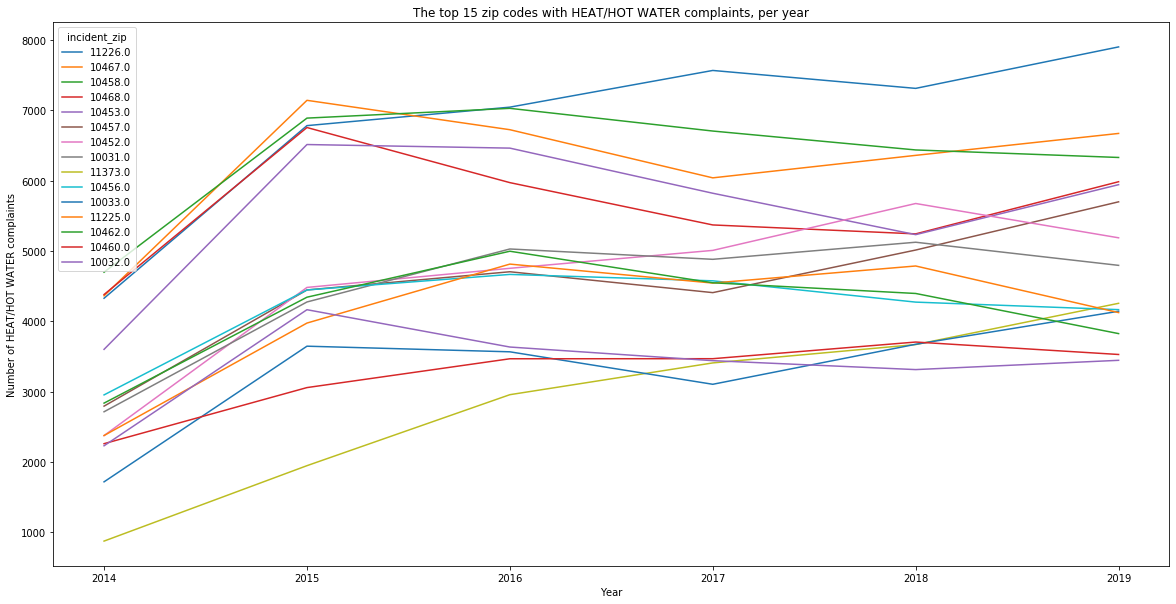

In [14]:
# Here we plot the number of HEAT/HOT WATER complaints per year for the 'top' problematic zip codes
top_yzc_cnt_df.T.plot(kind = 'line', figsize=(20,10))
plt.title('The top ' + str(TOP_NUM) + ' zip codes with HEAT/HOT WATER complaints, per year')
plt.ylabel('Number of HEAT/HOT WATER complaints')
plt.xlabel('Year')
plt.show()
plt.close()

As one can see from the plot above the zip codes may have different trends, for example consider the zip codes:

* **11226.0** -- is the worst zip code in *2017*, *2018* and *2019* and the number of complaints shows a growing trend;
* **10458.0** -- is the second worst in *2018* however the trend in the last four years is that the number of complaints declines;
* **11373.0** -- was performing the best in the beginning but is constantly growing over the years in complaint numbers and now it holds the *9*'th place;

The conclusion here is that the question on *'identifying the zip codes to concentrate on'* is not concrete enough. One can say that we shall concentrate on the zip codes with the trend of growing in the number of complaints. Another may say we shall concentrate on the zip codes with the top *'X'* number of complains in the last year.

## Average numer of complaints per zip code

Below we shall consider the average number of complaints per year and then concentrate on the outlier zip codes, i.e. the ones that have 'exceptionally many' complaints. We shall see this approach as a complementary one to the approach taken in the previous section. Later we will join the results of both approaches to be able to draw more objective conclusions.

Let us begin by computing the average number of complaints per zip code for all the years. We will convert the resulting vaalues into integers for better readability. This will not influence the result as the decimal number of complaints do not have any meaning.

In [15]:
# Group by the zip code and count the number of complaints, the get the average number over the years
print('The number of considered years is:', NUM_YEARS)
zip_df = dhp_df.groupby('incident_zip').size().apply(lambda x: x/NUM_YEARS).sort_values(axis=0, ascending = False).to_frame()
zip_df.columns = ['avg_count']

# Convert to integer to better readability
zip_df = zip_df.astype(int)
display(zip_df.head())

The number of considered years is: 6


,avg_count
incident_zip,
11226.0,6824
10458.0,6349
10467.0,6218
10468.0,5618
10453.0,5596


Please note that, the top 5 problematic zip codes in the listing above are the same as the top 5 zip codes in the plot presented in the previous section. This gives us confidence in the selected approach.

Let us now use a boxplot to show the distribution of the average number of complaints per zip code area. This plot will also show outliers:

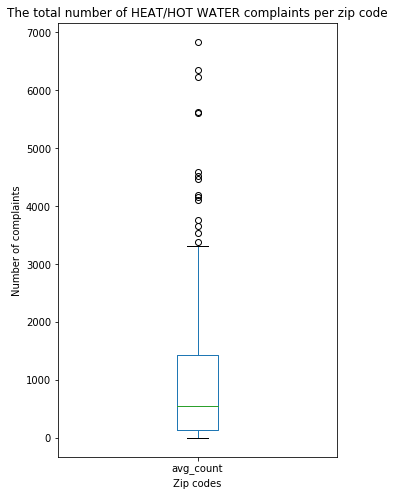

In [16]:
# Let us now plot the number of complaints per zip code
# as a box plot, to see if there any any outliers.
zip_df.plot(kind = 'box', figsize = (5,8))
plt.ylabel('Number of complaints')
plt.xlabel('Zip codes')
plt.title('The total number of HEAT/HOT WATER complaints per zip code')
plt.show()
plt.close()

As one can see from the plot above there are a number of zip codes which can be considered  as outliers in a sense of the extreme numbers of 'HEAT/HOT WATER' complaints. Let us list them explicitly by computing the interquartile ranges and getting the outliers bound. The boxplot ourliers are computed based on the 1.5 interquartile range, see the computations below:

In [17]:
# Lust the outlier zip codes 
Q1 = zip_df.quantile(0.25)
Q3 = zip_df.quantile(0.75)
IQR = Q3 - Q1
BOUND = Q3 + 1.5 * IQR

print('The avg_count outliers bound value is:', BOUND[0])
print('The zip codes that should get our attention are:')
top_zip_df = zip_df[zip_df['avg_count'] > int(BOUND)]
print('The number of problematic zip codes to consider is:', top_zip_df.shape[0])
display(top_zip_df)

The avg_count outliers bound value is: 3354.25
The zip codes that should get our attention are:
The number of problematic zip codes to consider is: 15


,avg_count
incident_zip,
11226.0,6824
10458.0,6349
10467.0,6218
10468.0,5618
10453.0,5596
10452.0,4580
10457.0,4511
10031.0,4470
10456.0,4180


As we see there is 15 outlier zip codes identified by the abalysis above. Remember that, in the previous section we also plotted the top 15 problematic zip codes, as resulted from another analysis approach.

## Combining the two approaches

Let us now check if the top 15 outlier zip codes computed with the two different approaches overlap. This will allow us to get more confidence in the results and the zip code areas identified as problematic by both the approaches will be taken into the final recomendations.

Let use join the results from the two data frames by doing the outer join, and then cleaning the data and restoring the order of rows by sorting:

In [18]:
# Let us make an outer joint of the two tables
zip_sum = pd.merge(top_yzc_cnt_df, top_zip_df, left_index = True, right_index = True, how = 'outer')

# Make the table look nice by filling in the NaN values and type conversion
zip_sum = zip_sum.fillna(0).astype(int)

# Restore the ordering
order = ['avg_count']
order.extend(years)
print('Order the resulting table by columns:', order)
zip_sum = zip_sum.sort_values(by = order, ascending = False)

# Display the results
display(zip_sum)

Order the resulting table by columns: ['avg_count', 2019, 2018, 2017, 2016, 2015, 2014]


,2014,2015,2016,2017,2018,2019,avg_count
incident_zip,,,,,,,
11226.0,4328,6784,7047,7569,7314,7904,6824
10458.0,4699,6891,7030,6707,6438,6331,6349
10467.0,4363,7144,6726,6041,6361,6673,6218
10468.0,4381,6757,5973,5371,5244,5986,5618
10453.0,3601,6515,6464,5822,5233,5944,5596
10452.0,2374,4482,4754,5009,5676,5188,4580
10457.0,2793,4446,4705,4408,5014,5700,4511
10031.0,2713,4275,5029,4882,5125,4796,4470
10456.0,2953,4446,4667,4576,4273,4166,4180


## Conclusions (zip codes):

As one can see from the joint table above the first 11 entries are the same for the both approaches we used to identify the most problematic zip codes. Moreover, the order of importance is also almost (with some exceptions) preserved.

The suggestion would be to concentrate on, e.g., the top 5 zip code entries of the zip_sum data frame:

In [19]:
print('The top 5 problematic zip code areas:', zip_sum.index[0:5].to_list())

The top 5 problematic zip code areas: [11226.0, 10458.0, 10467.0, 10468.0, 10453.0]


# Analysis for streets

In this section we are required to analyze whether there are streets that should require extra attention because of the exceptional amounts of the 'HEAT/HOT WATER' complaints.

Clearly, the analysis should down to the same approach as was already taken to analyze the problematic zip code areas. However, there is one question that is to be answered before we can start, namely:

> "Are the street names unique or can there be the same street name in different borough or zip code areas?"

If answered positively, we will not be able to do the analysis at the street level as:
1. There may be different streets with the same in different borough or zip code areas, and 
2. There may be streets what just stratch throughout several locations.

So counting the number of complaints by the street name we will then not be able to distinguish between these two cases and thus we may occasionally mix counts from two distinct streets with the same name.

Let us not answer the question posed above, first for the boroughs and then for the zip codes.

First, let us group by the street name and then borough and see if there are streets with more than one borough:

In [20]:
# Group by the street name and then get the list of unique boroughs the street is present in
sb_df = dhp_df.groupby(by=['street_name'])['borough'].unique().to_frame()

# Count the number of boroughs per street
sb_df['borough_count'] = sb_df['borough'].apply(len)

# Order streets by the borough count
sb_df.sort_values(by = ['borough_count'], axis = 0, inplace = True, ascending = False)

# Display the result
display(sb_df.head())

,borough,borough_count
street_name,,
BROADWAY,"[BROOKLYN, MANHATTAN, BRONX, QUEENS, STATEN IS...",5
PARK AVENUE,"[MANHATTAN, BROOKLYN, BRONX, STATEN ISLAND, QU...",5
WARREN STREET,"[QUEENS, BROOKLYN, MANHATTAN, STATEN ISLAND]",4
METROPOLITAN AVENUE,"[BRONX, QUEENS, BROOKLYN, STATEN ISLAND]",4
CLINTON AVENUE,"[BROOKLYN, BRONX, STATEN ISLAND, QUEENS]",4


From the results in the table above we see that there are streets with names present in different boroughs.

What about the zip code areas? Can we expect that the same street name is only present within one zip code area?

In [21]:
# Group by the street name and then get the list of unique boroughs the street is present in
sz_df = dhp_df.groupby(by=['street_name'])['incident_zip'].unique().to_frame()

# Count the number of boroughs per street
sz_df['zip_count'] = sz_df['incident_zip'].apply(len)

# Order streets by the borough count
sz_df.sort_values(by = ['zip_count'], axis = 0, inplace = True, ascending = False)

# Display the result
display(sz_df.head())

,incident_zip,zip_count
street_name,,
BROADWAY,"[11221.0, 10031.0, 10025.0, 10033.0, 10032.0, ...",35
5 AVENUE,"[11232.0, 10037.0, 11215.0, 11217.0, 10029.0, ...",26
3 AVENUE,"[11209.0, 10003.0, 11217.0, 10451.0, 10456.0, ...",24
PARK AVENUE,"[10029.0, 11205.0, 10458.0, 11206.0, 10037.0, ...",20
2 AVENUE,"[10003.0, 10035.0, 10029.0, 10065.0, 10128.0, ...",17


From the table above we see that, once again, there are streets with names present in different zip code areas.

## Conclusions (streets):
Clearly, a street name does not have to be unique within a country, city or even a borough, even though it is very likely it is unique for a single zip code. Therefore, the streets with names present in different boroughs or zip code areas can be the same or different streets.

Our results show that there are quite alot of such streets:

In [22]:
print('Number of equally named streets present in different:')
print('  - boroughs:', (sb_df['borough_count'] > 1).sum())
print('  - zip areas:', (sz_df['zip_count'] > 1).sum())

Number of equally named streets present in different:
  - boroughs: 733
  - zip areas: 2342


This means that, generally speaking we can not compute the exact number of 'HEAT/HOT WATER' complaints at the street level unless we can not distinguish different streets with the same names not bound to one zip area. Given the data set at hand the latter does not seem to be feasible, which means the street level analysis is generally not possible.

# Conclusions

The question hich we had to answer was:
    
> Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

Therefore, since the answer to Question 1 was: the 'HEAT/HOT WATER' complaints we went on with analyzing those.
The analysis was split into three sections:

* 'Analysis for boroughs'
* 'Analysis for zip code areas'
* 'Analysis for streets'

Each of these sections has its own local conclusions so here we shall just summarize:

The 'Analysis for boroughs' revealed that the top two critical boroughs are 'BRONX' and 'BROOKLYN':

In [23]:
display(borough_df)

,avg_count
borough,
BRONX,66878
BROOKLYN,62851
MANHATTAN,46701
QUEENS,27427
STATEN ISLAND,2017


The 'Analysis for zip code areas', by means of two different approaches, has disclosed that the top 5 problematic zip code areas are:

In [24]:
display(zip_sum.head())

,2014,2015,2016,2017,2018,2019,avg_count
incident_zip,,,,,,,
11226.0,4328,6784,7047,7569,7314,7904,6824
10458.0,4699,6891,7030,6707,6438,6331,6349
10467.0,4363,7144,6726,6041,6361,6673,6218
10468.0,4381,6757,5973,5371,5244,5986,5618
10453.0,3601,6515,6464,5822,5233,5944,5596


Finally, for the 'Analysis for streets' we have identified that there are equally named streets present in different boroughs and zip code areas:

In [25]:
print('Number of equally named streets present in different:')
print('  - boroughs:', (sb_df['borough_count'] > 1).sum())
print('  - zip areas:', (sz_df['zip_count'] > 1).sum())

Number of equally named streets present in different:
  - boroughs: 733
  - zip areas: 2342


Identifying unique streets, based on the data set at hand, is impossible. Therefore, the complaint analysis at the street level cound not be performed.

Please note that, all additional/detailed visualizations and analysis are present in the corresponding sections above.